In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.stats import chi2
import json

In [2]:
def lstsq_svd(a, b, rcond=None):
    a = np.atleast_2d(a)
    b = np.atleast_1d(b)
    u, s, vh = np.linalg.svd(a, full_matrices=False)
    if rcond is None:
        where = (s != 0.0)
    else:
        where = s > s[0] * rcond
    x = vh.T @ np.divide(u.T[:s.shape[0],:] @ b, s, out=np.zeros(a.shape[1]), where=where)
    r = a @ x - b
    cost = np.inner(r, r)
    sigma0 = cost / (b.shape[0] - x.shape[0])
    var = vh.T @ np.diag(s**(-2)) @ vh * sigma0
    
    return x, cost, var

In [3]:
def lstsq_ne(a, b):
    a = np.atleast_2d(a)
    b = np.atleast_1d(b)
    x = np.linalg.inv(a.T @ a) @ A.T @ b
    r = a @ x - b
    cost = np.inner(r, r)
    sigma0 = cost / (b.shape[0] - x.shape[0])
    var = np.linalg.inv(a.T @ a) * sigma0

    return x, cost, var

In [4]:
def lstsq(a, b, method, **kwargs):
    if method == 'ne':
        return lstsq_ne(a, b)
    return lstsq_svd(a, b, **kwargs)

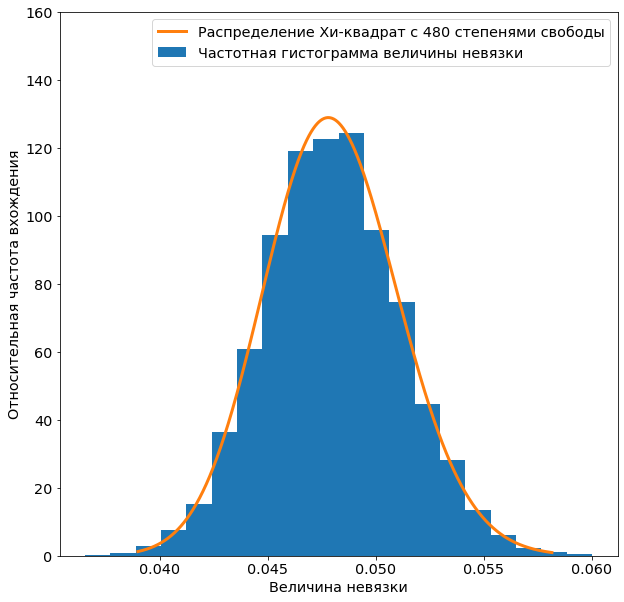

In [5]:
    A = np.random.sample((500,20))
    x = np.random.sample(20)
    nev = []
    var = 0.01
    for i in range(10000):
        b = np.random.normal(A @ x, var)
        x, cost, vari = lstsq(A, b, 'svd')
        nev.append(cost)
    df = A.shape[0] - x.shape[0]
    x = np.linspace(chi2.ppf(0.001, df), chi2.ppf(0.999, df), 1000)
    plt.figure(figsize=(10, 10))
    plt.hist(nev, bins = 20, density = True, label='Частотная гистограмма величины невязки')
    plt.plot(x*var*var, chi2.pdf(x, df)/(var*var), lw = 3, label='Распределение Хи-квадрат с 480 степенями свободы')
    plt.xlabel("Величина невязки", fontsize='x-large')
    plt.ylabel("Относительная частота вхождения", fontsize='x-large')
    plt.legend(loc='upper right' , fontsize='x-large')
    plt.ylim(0, 160)
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')
    plt.savefig('chi2.png')

9.56143718798346e-05 100.46714170244285


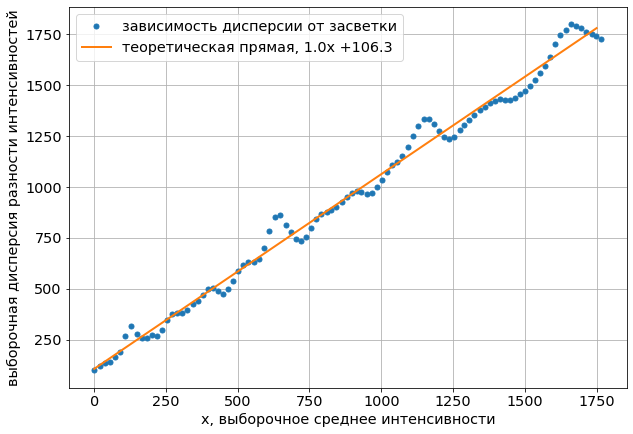

In [20]:
    with fits.open("ccd.fits") as hdl:
        x = hdl[0]
        data = np.array(x.data, dtype='float')
    std = np.var(data[:, 0] - data[:, 1], axis = (1, 2))
    mean_0 = np.mean(data[0])
    data += -mean_0
    mean = np.mean(data[:, 0]+ data[:, 1], axis = (1, 2))/2
    D = np.zeros((100, 2)) + 1
    D[:,0] = mean
    ans, gb1, var = lstsq(D, std, 'svd')
    xx = np.linspace(0, 1750, 2)
    yy = xx*ans[0] + ans[1]
    plt.figure(figsize=(10, 7))
    plt.plot(mean, std, 'o', ms=5, label='зависимость дисперсии от засветки')
    plt.plot(xx, yy, lw = 2, label='теоретическая прямая, {:.1f}x +{:.1f}'.format(ans[0], ans[1]))
    plt.xlabel("х, выборочное среднее интенсивности", fontsize='x-large')
    plt.ylabel("выборочная дисперсия разности интенсивностей", fontsize='x-large')
    plt.grid()
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')
    plt.legend(fontsize='x-large')
    plt.savefig('ccd.png')
    print(var[0,0], var[1,1])
    g = 2/ans[0]
    ron = np.sqrt(ans[1]/2)*g
    g_err = np.sqrt((2/ans[0]**2)**2 * var[0, 0])
    ron_err = (1/(ans[0]*np.sqrt(2*ans[1])))** 2*var[1, 1]+(-np.sqrt(2*ans[1])/(ans[0]**2))**2*var[0, 0]
    ccd = {
        "ron": ron, 
        "ron_err": ron_err, 
        "gain": g, 
        "gain_err": g_err
        }
    with open('ccd.json', 'w') as f:
        json.dump(ccd, f)